In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Verinin yüklenmesi

In [2]:
current_dir = os.getcwd()
data_path = os.path.join(current_dir, "izmir_istasyon.csv")
data = pd.read_csv(data_path)
data.head()

,date,pm25,pm10,o3,no2,so2,co,Station
0,2023-12-05,86,16,11,5,2,8,aliaga
1,2023-12-06,109,26,8,4,3,9,aliaga
2,2023-12-08,79,19,16,9,2,8,aliaga
3,2023-12-09,56,7,9,4,1,8,aliaga
4,2023-12-11,145,21,13,16,4,9,aliaga


# Verideki özelliklerin tür analizi

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8046 entries, 0 to 8045
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     8046 non-null   object
 1    pm25    8046 non-null   object
 2    pm10    8046 non-null   object
 3    o3      8046 non-null   object
 4    no2     8046 non-null   object
 5    so2     8046 non-null   object
 6    co      8046 non-null   object
 7   Station  8046 non-null   object
dtypes: object(8)
memory usage: 503.0+ KB


# Özelliklerin isimlerindeki boşlukların kaldırılması ve numeric hale çevirilmesi

In [4]:
data.columns = data.columns.str.strip()

In [5]:
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
for col in pollutants:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col].astype(str), errors='coerce')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8046 entries, 0 to 8045
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     8046 non-null   object 
 1   pm25     6586 non-null   float64
 2   pm10     7449 non-null   float64
 3   o3       5043 non-null   float64
 4   no2      6240 non-null   float64
 5   so2      7182 non-null   float64
 6   co       6536 non-null   float64
 7   Station  8046 non-null   object 
dtypes: float64(6), object(2)
memory usage: 503.0+ KB


## İstasyon kontrolü

In [7]:
data['Station'].unique()

array(['aliaga', 'alsancak', 'bayrakli', 'bornova', 'cigli', 'gaziemir',
       'guzelyali', 'konak', 'sirinyer'], dtype=object)

# Pivot tablo formatının oluşturulması

In [8]:
data['date'] = pd.to_datetime(data['date'])

pivot_data = data.pivot(index='date', columns='Station', values=['pm25', 'pm10', 'o3', 'no2', 'so2', 'co'])

pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
new_columns = []
for pollutant in pollutants:
    for station in pivot_data.columns.levels[1]:
        new_columns.append((pollutant, station))

pivot_data.columns = pd.MultiIndex.from_tuples(new_columns)

full_date_range = pd.date_range(start=pivot_data.index.min(), end=pivot_data.index.max(), freq='D')

pivot_data = pivot_data.reindex(full_date_range)

pivot_data.index.name = 'date'

pivot_data.head()

pm25                                                            \
           aliaga alsancak bayrakli bornova  cigli gaziemir guzelyali konak   
date                                                                          
2022-01-01    NaN    143.0    143.0   143.0  101.0    143.0     143.0   NaN   
2022-01-02    NaN    186.0    186.0   186.0  135.0    186.0     186.0   NaN   
2022-01-03    NaN    134.0    134.0   134.0   80.0    134.0     134.0   NaN   
2022-01-04    NaN    161.0    161.0   161.0   95.0    161.0     161.0   NaN   
2022-01-05    NaN    154.0    154.0   154.0   93.0    154.0     154.0   NaN   

                      pm10  ...      so2     co                            \
           sirinyer aliaga  ... sirinyer aliaga alsancak bayrakli bornova   
date                        ...                                             
2022-01-01    143.0    NaN  ...     11.0    NaN     18.0     18.0     1.0   
2022-01-02    186.0    NaN  ...      9.0    NaN     15.0     15.0     1.0   
2022-01-03    134.0    NaN  ...      9.0    NaN     15.0     15.0     1.0   
2022-01-04    161.0    NaN  ...      5.0    NaN     13.0     13.0     2.0   
2022-01-05    154.0    NaN  ...      7.0    NaN     10.0     10.0     2.0   

                                                    
           cigli gaziemir guzelyali konak sirinyer  
date                                                
2022-01-01  18.0     18.0       4.0   NaN     18.0  
2022-01-02  15.0     15.0       3.0   NaN     15.0  
2022-01-03  15.0     15.0       3.0   NaN     15.0  
2022-01-04  13.0     13.0       2.0   NaN     13.0  
2022-01-05  10.0     10.0       1.0   NaN     10.0  

[5 rows x 54 columns]

# Döngü içerisinde her bir istasyon için değerlerin görselleştirilmesi ve izlenmesi

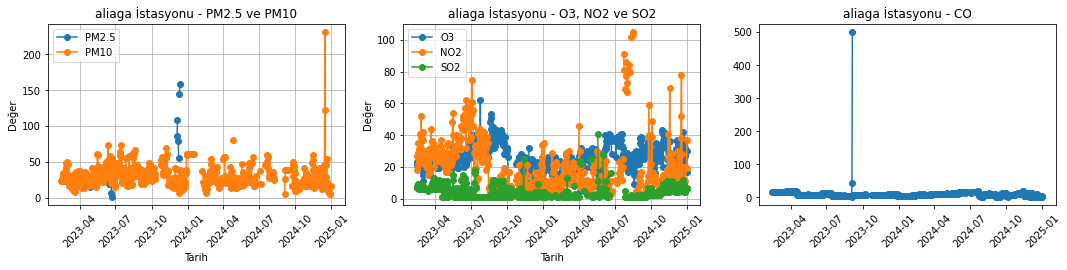

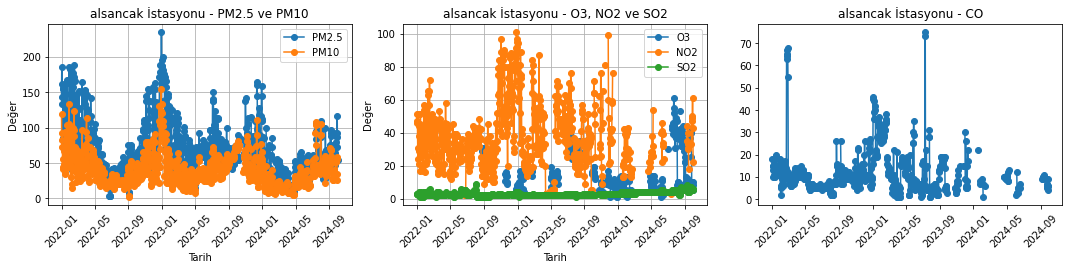

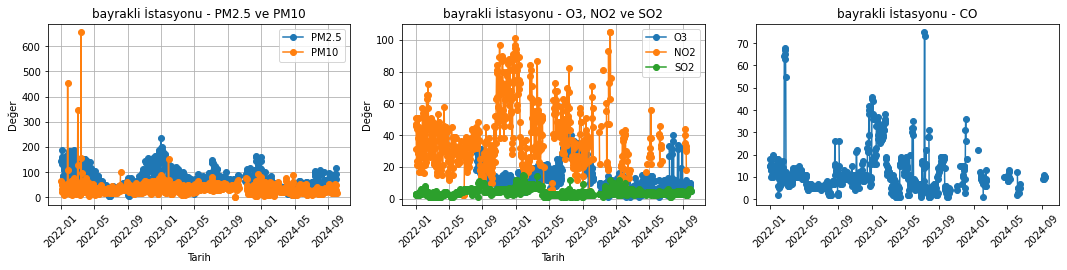

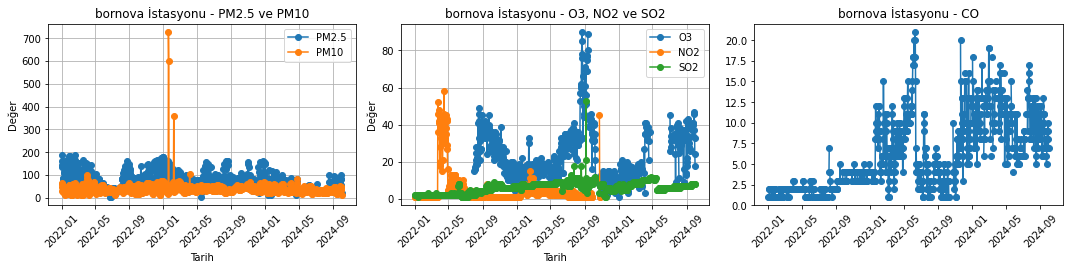

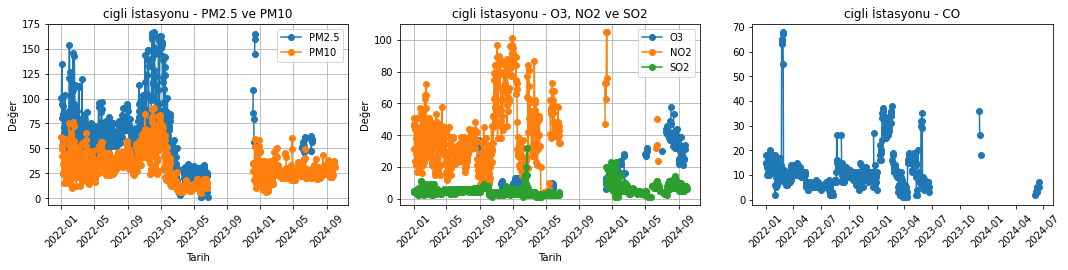

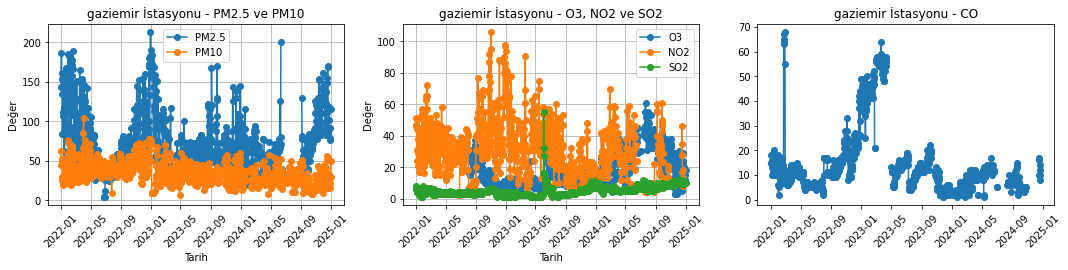

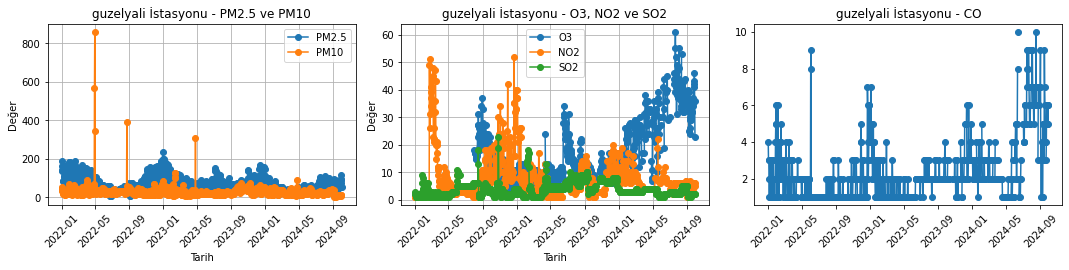

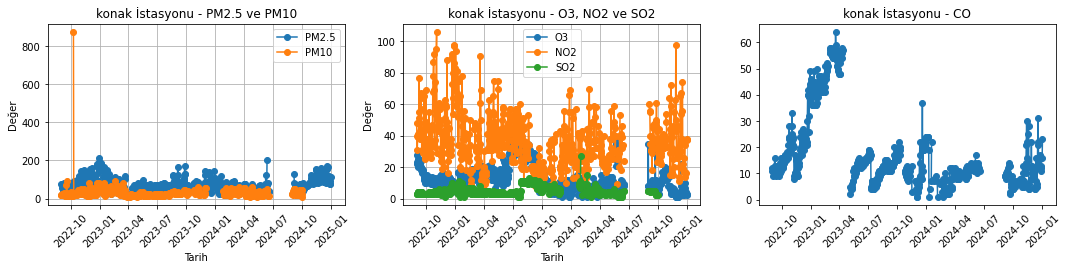

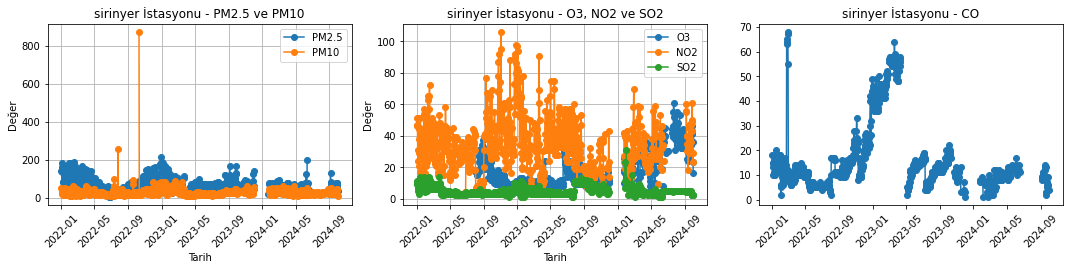

In [9]:
stations = pivot_data.columns.levels[1]

for station in stations:
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 3, 1)
    plt.plot(pivot_data.index, pivot_data['pm25'][station], label='PM2.5', marker='o')
    plt.plot(pivot_data.index, pivot_data['pm10'][station], label='PM10', marker='o')
    plt.title(f'{station} İstasyonu - PM2.5 ve PM10')
    plt.xlabel('Tarih')
    plt.ylabel('Değer')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    plt.subplot(3, 3, 2)
    plt.plot(pivot_data.index, pivot_data['o3'][station], label='O3', marker='o')
    plt.plot(pivot_data.index, pivot_data['no2'][station], label='NO2', marker='o')
    plt.plot(pivot_data.index, pivot_data['so2'][station], label='SO2', marker='o')
    plt.title(f'{station} İstasyonu - O3, NO2 ve SO2')
    plt.xlabel('Tarih')
    plt.ylabel('Değer')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    plt.subplot(3, 3, 3)
    plt.plot(pivot_data.index, pivot_data['co'][station], label='CO', marker='o')
    plt.title(f'{station} İstasyonu - CO')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Verinin boyutunun kontrolü, 365x3=1095, 1 gün artık yıl ve bir gün de ocak 1 dahiliyetinden geliyor

In [10]:
pivot_data.shape


(1097, 54)

# Eksik veri analizi ve interpolate, backfill yöntemleri ile doldurulması

In [11]:
print(pivot_data.isna().sum())

pm25  aliaga       1047
      alsancak      172
      bayrakli      184
      bornova       256
      cigli         533
      gaziemir      191
      guzelyali     165
      konak         426
      sirinyer      313
pm10  aliaga        557
      alsancak      173
      bayrakli      196
      bornova       166
      cigli         318
      gaziemir      107
      guzelyali     171
      konak         521
      sirinyer      215
o3    aliaga        497
      alsancak      844
      bayrakli      420
      bornova       444
      cigli         951
      gaziemir      353
      guzelyali     436
      konak         414
      sirinyer      471
no2   aliaga        536
      alsancak      378
      bayrakli      407
      bornova       533
      cigli         566
      gaziemir      240
      guzelyali     230
      konak         427
      sirinyer      316
so2   aliaga        647
      alsancak      184
      bayrakli      226
      bornova       196
      cigli         350
      gaziemir  

In [12]:
pivot_data = pivot_data.interpolate(method='linear') 
pivot_data.isna().sum()

pm25  aliaga       415
      alsancak       0
      bayrakli       0
      bornova        0
      cigli          0
      gaziemir       0
      guzelyali      0
      konak        244
      sirinyer       0
pm10  aliaga       408
      alsancak       0
      bayrakli       0
      bornova        0
      cigli          0
      gaziemir       0
      guzelyali      0
      konak        243
      sirinyer       0
o3    aliaga       408
      alsancak     238
      bayrakli     220
      bornova      213
      cigli        239
      gaziemir     213
      guzelyali    213
      konak        243
      sirinyer     213
no2   aliaga       408
      alsancak       0
      bayrakli       0
      bornova        0
      cigli          0
      gaziemir       0
      guzelyali      0
      konak        243
      sirinyer       0
so2   aliaga       408
      alsancak       0
      bayrakli       0
      bornova        0
      cigli          0
      gaziemir       0
      guzelyali      0
      konak

In [13]:
pivot_data = pivot_data.bfill()

In [14]:
pivot_data.isna().sum()

pm25  aliaga       0
      alsancak     0
      bayrakli     0
      bornova      0
      cigli        0
      gaziemir     0
      guzelyali    0
      konak        0
      sirinyer     0
pm10  aliaga       0
      alsancak     0
      bayrakli     0
      bornova      0
      cigli        0
      gaziemir     0
      guzelyali    0
      konak        0
      sirinyer     0
o3    aliaga       0
      alsancak     0
      bayrakli     0
      bornova      0
      cigli        0
      gaziemir     0
      guzelyali    0
      konak        0
      sirinyer     0
no2   aliaga       0
      alsancak     0
      bayrakli     0
      bornova      0
      cigli        0
      gaziemir     0
      guzelyali    0
      konak        0
      sirinyer     0
so2   aliaga       0
      alsancak     0
      bayrakli     0
      bornova      0
      cigli        0
      gaziemir     0
      guzelyali    0
      konak        0
      sirinyer     0
co    aliaga       0
      alsancak     0
      bayrakl

# Doldurulmuş verilerin her istasyon için görselleştirilmesi

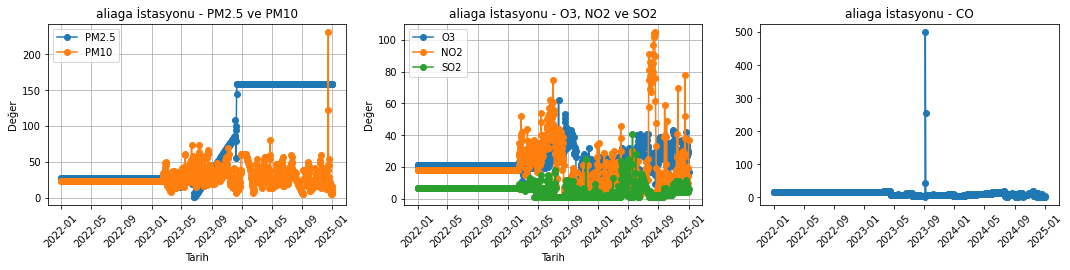

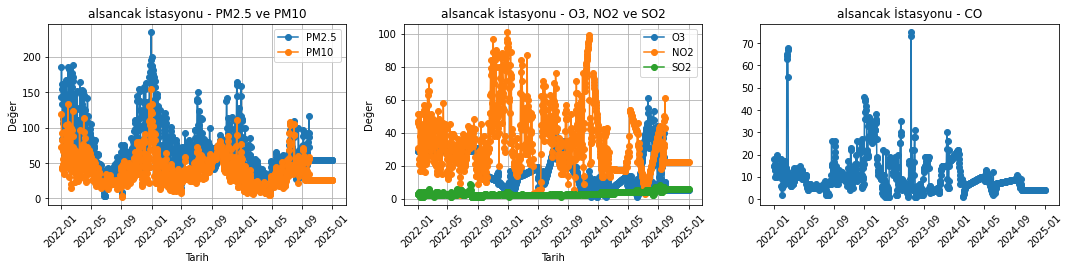

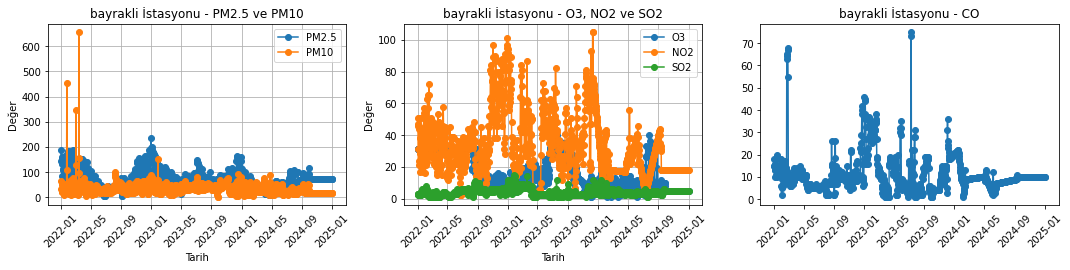

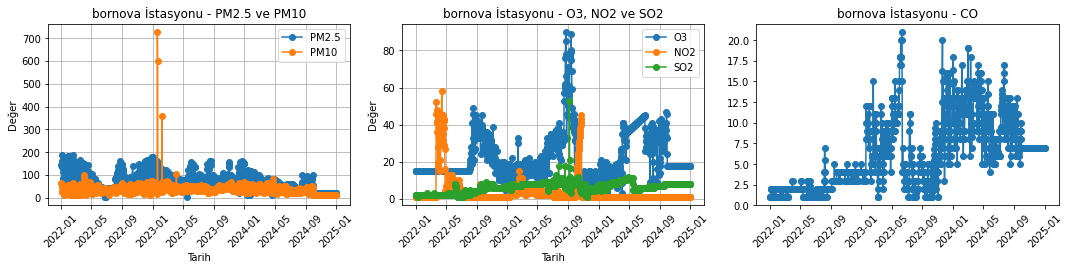

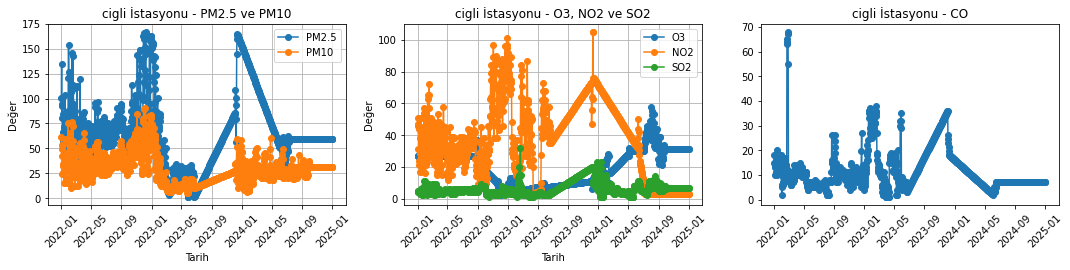

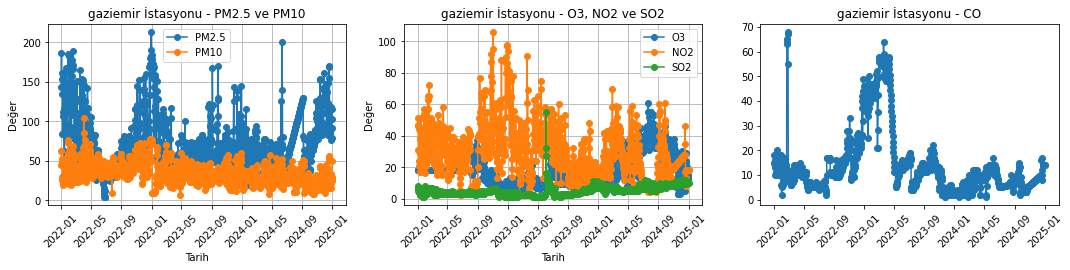

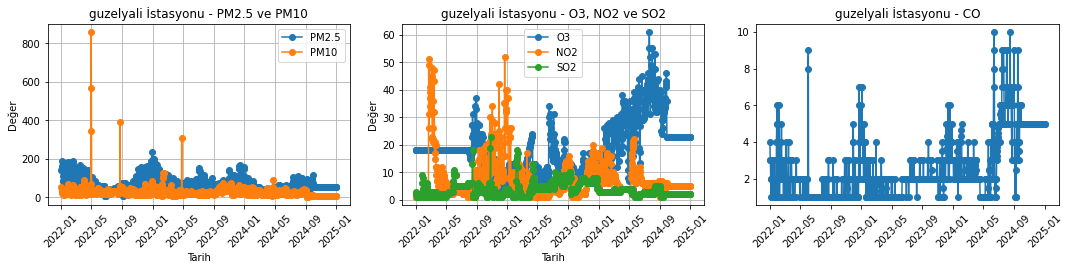

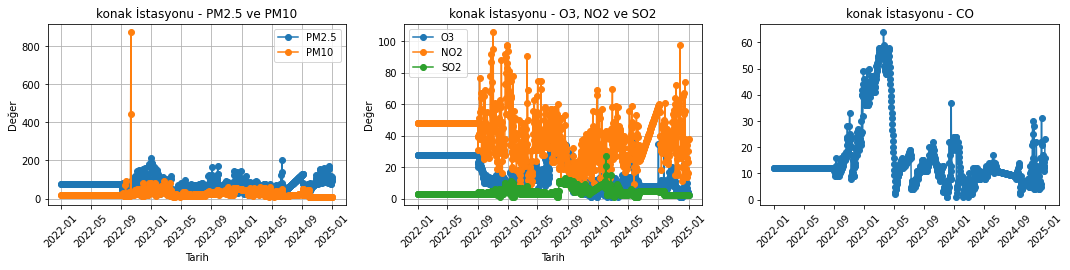

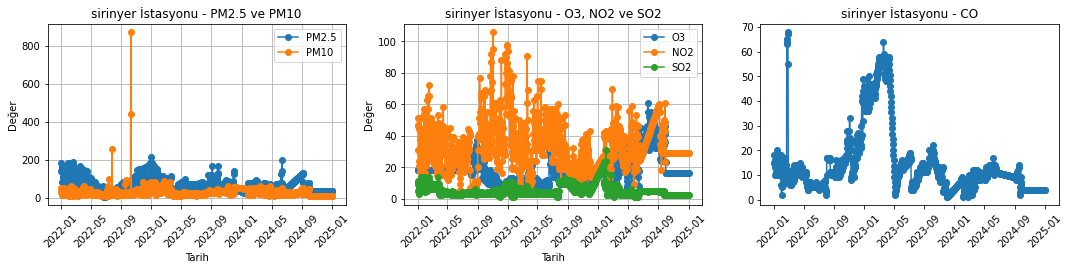

In [15]:
stations = pivot_data.columns.levels[1]

for station in stations:
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 3, 1)
    plt.plot(pivot_data.index, pivot_data['pm25'][station], label='PM2.5', marker='o')
    plt.plot(pivot_data.index, pivot_data['pm10'][station], label='PM10', marker='o')
    plt.title(f'{station} İstasyonu - PM2.5 ve PM10')
    plt.xlabel('Tarih')
    plt.ylabel('Değer')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    plt.subplot(3, 3, 2)
    plt.plot(pivot_data.index, pivot_data['o3'][station], label='O3', marker='o')
    plt.plot(pivot_data.index, pivot_data['no2'][station], label='NO2', marker='o')
    plt.plot(pivot_data.index, pivot_data['so2'][station], label='SO2', marker='o')
    plt.title(f'{station} İstasyonu - O3, NO2 ve SO2')
    plt.xlabel('Tarih')
    plt.ylabel('Değer')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

    plt.subplot(3, 3, 3)
    plt.plot(pivot_data.index, pivot_data['co'][station], label='CO', marker='o')
    plt.title(f'{station} İstasyonu - CO')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
pivot_data.duplicated().unique()

array([False])

# Referans istasyonu Gaziemir olarak seçilmiştir

In [17]:
gaziemir_data = pivot_data.xs('gaziemir', level=1, axis=1)

print(gaziemir_data.head())
print(gaziemir_data.columns)

             pm25  pm10    o3   no2  so2    co
date                                          
2022-01-01  143.0  62.0  18.0  46.0  8.0  18.0
2022-01-02  186.0  44.0  18.0  51.0  6.0  15.0
2022-01-03  134.0  52.0  18.0  47.0  6.0  15.0
2022-01-04  161.0  48.0  18.0  31.0  5.0  13.0
2022-01-05  154.0  30.0  18.0  24.0  4.0  10.0
Index(['pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], dtype='object')


# Air Quality Index hesaplaması

In [18]:
def calculate_aqi(pollutant, concentration):
    if pollutant == 'pm25':
        if concentration <= 12:
            return concentration * 1
        elif concentration <= 35.4:
            return 12 + (concentration - 12) * (1 / 23.4)
        elif concentration <= 55.4:
            return 35.4 + (concentration - 35.4) * (1 / 19.6)
        elif concentration <= 150.4:
            return 55.4 + (concentration - 55.4) * (1 / 94.6)
        elif concentration <= 250.4:
            return 150.4 + (concentration - 150.4) * (1 / 99.6)
        elif concentration <= 500.4:
            return 250.4 + (concentration - 250.4) * (1 / 249.6)
        else:
            return 500
    elif pollutant == 'pm10':
        if concentration <= 54:
            return concentration * 1
        elif concentration <= 154:
            return 54 + (concentration - 54) * (1 / 100)
        elif concentration <= 254:
            return 154 + (concentration - 154) * (1 / 100)
        elif concentration <= 354:
            return 254 + (concentration - 254) * (1 / 100)
        elif concentration <= 424:
            return 354 + (concentration - 354) * (1 / 100)
        elif concentration <= 604:
            return 424 + (concentration - 424) * (1 / 100)
        else:
            return 600
    elif pollutant == 'o3':
        if concentration <= 54:
            return concentration * 1
        elif concentration <= 70:
            return 54 + (concentration - 54) * (1 / 16)
        elif concentration <= 85:
            return 70 + (concentration - 70) * (1 / 15)
        elif concentration <= 105:
            return 85 + (concentration - 85) * (1 / 20)
        elif concentration <= 200:
            return 105 + (concentration - 105) * (1 / 95)
        else:
            return 500
    elif pollutant == 'no2':
        if concentration <= 53:
            return concentration * 1
        elif concentration <= 100:
            return 53 + (concentration - 53) * (1 / 47)
        elif concentration <= 360:
            return 100 + (concentration - 100) * (1 / 260)
        elif concentration <= 649:
            return 360 + (concentration - 360) * (1 / 289)
        else:
            return 500
    elif pollutant == 'so2':
        if concentration <= 35:
            return concentration * 1
        elif concentration <= 75:
            return 35 + (concentration - 35) * (1 / 40)
        elif concentration <= 185:
            return 75 + (concentration - 75) * (1 / 110)
        elif concentration <= 304:
            return 185 + (concentration - 185) * (1 / 119)
        else:
            return 500
    elif pollutant == 'co':
        if concentration <= 4.4:
            return concentration * 1
        elif concentration <= 9.4:
            return 4.4 + (concentration - 4.4) * (1 / 5)
        elif concentration <= 12.4:
            return 9.4 + (concentration - 9.4) * (1 / 3)
        elif concentration <= 15.4:
            return 12.4 + (concentration - 12.4) * (1 / 3)
        elif concentration <= 30.4:
            return 15.4 + (concentration - 15.4) * (1 / 15)
        else:
            return 500
    return None

gaziemir_data = pivot_data.xs('gaziemir', level=1, axis=1)

aqi_data = pd.DataFrame(index=gaziemir_data.index)

aqi_data['AQI'] = gaziemir_data.apply(
    lambda row: max(
        calculate_aqi('pm25', row['pm25']),
        calculate_aqi('pm10', row['pm10']),
        calculate_aqi('o3', row['o3']),
        calculate_aqi('no2', row['no2']),
        calculate_aqi('so2', row['so2']),
        calculate_aqi('co', row['co'])
    ),
    axis=1
)

print(aqi_data.head())

                   AQI
date                  
2022-01-01   56.326004
2022-01-02  150.757430
2022-01-03   56.230867
2022-01-04  150.506426
2022-01-05  150.436145


# Aykırı değerleri çıkarmak yerine lower ve upper limitlere çekilmesi

In [19]:
Q1 = aqi_data['AQI'].quantile(0.25)
Q3 = aqi_data['AQI'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

aqi_data['AQI'] = np.clip(aqi_data['AQI'], lower_limit, upper_limit)

# Verinin ölçeklenmesi için MinMaxScaler kullanımı

In [20]:
scaler = MinMaxScaler()
aqi_data = scaler.fit_transform(aqi_data)
aqi_data = aqi_data.astype('float32')

In [21]:
aqi_data[0:5]

array([[0.63342166],
       [1.        ],
       [0.63142705],
       [1.        ],
       [1.        ]], dtype=float32)

# Train, test verilerinin ayrılması

In [22]:
TRAIN_SIZE = 0.80

train_size = int(len(aqi_data)*TRAIN_SIZE)
test_size = len(aqi_data) - train_size

train, test = aqi_data[0:train_size, :], aqi_data[train_size:len(aqi_data),:]
print("Gün sayilari (training set, test set) : " + str((len(train),len(test))))

Gün sayilari (training set, test set) : (877, 220)


# Ayrılan veri setlerinin LSTM modeline uygun inputlar haline getirilmesi

In [23]:
def veri_yap(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [24]:
window_size = 14
train_X, train_Y = veri_yap(train, window_size)
test_X, test_Y = veri_yap(test, window_size)
print("Orijinal train veri şekli:")
print(train_X.shape)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("Yeni train veri şekli:")
print(train_X.shape)

Orijinal train veri şekli:
(862, 14)
Yeni train veri şekli:
(862, 1, 14)


In [25]:
np.random.seed(42)
random.seed(42)

# Model Eğitimi

In [26]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(Bidirectional(LSTM(100, 
                dropout=0.2,return_sequences=True),input_shape = (1, window_size)))
    model.add(LSTM(100, dropout=0.2, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
   
    model.fit(train_X, 
              train_Y, 
              epochs = 50, 
              batch_size = 5, 
              verbose = 1)
    
    return(model)

model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/50
173/173 [==============================] - 7s 4ms/step - loss: 0.0471
Epoch 2/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0325
Epoch 3/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0352
Epoch 4/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0303
Epoch 5/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0318
Epoch 6/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0316
Epoch 7/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0321
Epoch 8/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0320
Epoch 9/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0315
Epoch 10/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0319
Epoch 11/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0330
Epoch 12/50
173/173 [==============================] - 1s 4ms/step - loss: 0.0321
Epoch 13/50
173/173 [====

# Modelin değerlendirilmesi ve sonuçların görselleştirilmesi

In [27]:
def tahminveskor(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform(Y.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(orig_data, pred[:, 0]))
    mae = mean_absolute_error(orig_data, pred[:, 0])
    r2 = r2_score(orig_data, pred[:, 0])
    mape = np.mean(np.abs((orig_data - pred[:, 0]) / orig_data)) * 100

    return rmse, mae, r2, mape, pred
rmse_train, mae_train, r2_train, mape_train, train_pred = tahminveskor(model1, train_X, train_Y)
rmse_test, mae_test, r2_test, mape_test, test_pred = tahminveskor(model1, test_X, test_Y)

print("Training data metrics:")
print("RMSE: %.2f, MAE: %.2f, R2: %.2f, MAPE: %.2f%%" % (rmse_train, mae_train, r2_train, mape_train))

print("Test data metrics:")
print("RMSE: %.2f, MAE: %.2f, R2: %.2f, MAPE: %.2f%%" % (rmse_test, mae_test, r2_test, mape_test))


7/7 [==============================] - 0s 2ms/step
Training data metrics:
RMSE: 7.92, MAE: 6.85, R2: 0.58, MAPE: 23.82%
Test data metrics:
RMSE: 6.80, MAE: 5.80, R2: 0.30, MAPE: 16.13%


7/7 [==============================] - 0s 2ms/step


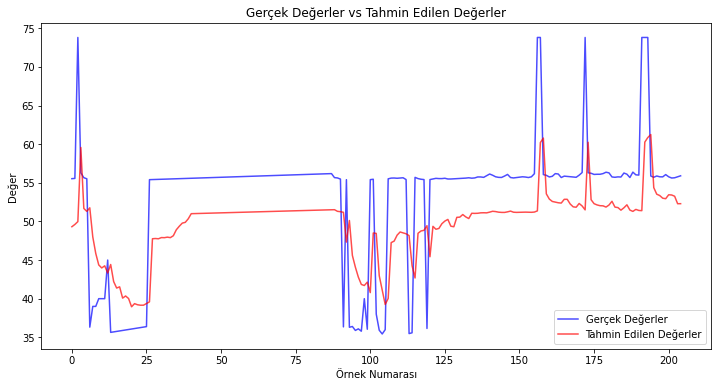

In [28]:
test_pred = scaler.inverse_transform(model1.predict(test_X))
orig_test_data = scaler.inverse_transform(test_Y.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(orig_test_data, label="Gerçek Değerler", color="blue", alpha=0.7)
plt.plot(test_pred, label="Tahmin Edilen Değerler", color="red", alpha=0.7)
plt.title("Gerçek Değerler vs Tahmin Edilen Değerler")
plt.xlabel("Örnek Numarası")
plt.ylabel("Değer")
plt.legend()
plt.show()


# İzmir için Aralığın son 2 haftasındaki veriyi girdi olarak kullanarak Ocak'ın ilk 2 haftasının tahmin edilmesi

1/1 [==============================] - 0s 25ms/step
Tahmin Edilen AQI Değerleri (Ocak Ayının 2'inden 15'ine kadar tahminler):
Gün 1: 97.64
Gün 2: 103.61
Gün 3: 104.91
Gün 4: 88.35
Gün 5: 108.51
Gün 6: 108.58
Gün 7: 93.47
Gün 8: 93.42
Gün 9: 88.68
Gün 10: 93.23
Gün 11: 97.78
Gün 12: 89.27
Gün 13: 82.37
Gün 14: 84.45


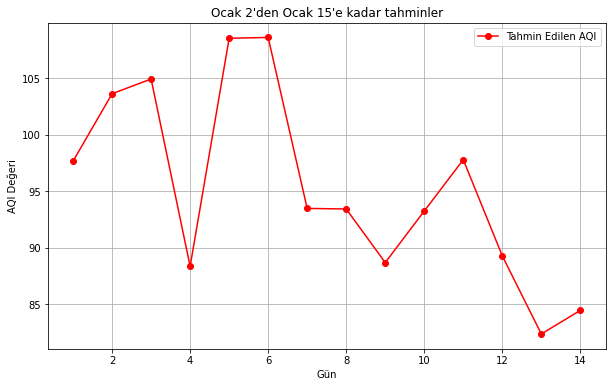

In [29]:
initial_input = np.array([[55, 55, 23, 22, 30, 14, 24, 39, 28, 18, 29, 21, 30, 45]])
current_input = initial_input.reshape((1, 1, initial_input.shape[1]))

predicted_aqi = []

for day in range(14): 
    next_prediction = model1.predict(current_input)  
    predicted_aqi.append(next_prediction[0, 0]) 
    next_prediction = next_prediction.reshape(1, 1, 1)  
    current_input = np.append(current_input[:, :, 1:], next_prediction, axis=2)


predicted_aqi = np.array(predicted_aqi)
predicted_aqi_original = scaler.inverse_transform(predicted_aqi.reshape(-1, 1))

print("Tahmin Edilen AQI Değerleri (Ocak Ayının 2'inden 15'ine kadar tahminler):")
for day, value in enumerate(predicted_aqi_original.flatten(), 1):
    print(f"Gün {day}: {value:.2f}")

days = range(1, 15) 
plt.figure(figsize=(10, 6))
plt.plot(days, predicted_aqi_original, marker='o', color='red', label="Tahmin Edilen AQI")
plt.title("Ocak 2'den Ocak 15'e kadar tahminler")
plt.xlabel("Gün")
plt.ylabel("AQI Değeri")
plt.legend()
plt.grid()
plt.show()
